In [7]:
## This Script takes a single or multiple process HDF5 files containing multiple channels, phases them together and plots them on a single graph. 
## The Files, Axis displays, Channel the recordings are phased together using and the amplitude are all user definable. 
## Ensure that all input files have the same number of columns and column order. The script prints the files and their repective channels at the start of the script. 


#Imported Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import h5py
from datetime import date
import matplotlib.lines as mlines
import matplotlib.figure as fig


#SETTING THE BASE DIRECTORY FOR THE PYTHON SCRIPT - IMPORTANT

#os.chdir(os.path.dirname(os.path.abspath(__file__))) # UN-HASH WHEN CONVERTED TO .PY SCRIPT. Used to set base directory in python terminal to enable relative input and output folder names to be used. 


# CONSTANTS 

InputFolder = "./Processed_HDF5_Files" # input file path
OutputFilePath = "Output_Plots" # Output Folder

# Color Dictionary Map for Plot
CMAP={ 0:"#1f77b4",1:"#ff7f0e", 2:"#2ca02c", 3: "#d62728",4:"#9467bd",5:"#8c564b", 6: "#7f7f7f", 7:"#dbdb8d", 8:"#bcbd22", 9:"#aec7e8", 10:"#ffbb78", 11:"#98df8a", 12:"#ff9896", 13:"#c5b0d5",14:"#c49c94",15:"#f7b6d2", 16:"#c7c7c7" } # color map dictionary


#Noteable Variables that might be adjusted. 

LineWeightCount = 1.5
LineWeightIncrement = 0.5




#Phasing Variable Setup
PhasingPointTime = 0 # setting up variable. Used in Phase function and gets set to the greatest time at which a certain amplitude value is reached in a specific dataset. 
TimeAfter = 0 # Setting up variable. Calculates the greatest time after the PhasingPointTime and the end of a dataset. 


# Plotting Variables

XScaleMin=-2 #scaling for X Axis - MIN - Assuming Time - Gives a good buffer to the left hand side.  - NOT CURRENTLY USED


# Functions

def InputVariableNumberCheckerFloat(Value,Defaultvalue): # function confirms input string can be converted to a float. If not it returns a default value which is given as the second arugment with the function.  
    try:
        float(Value) # try to see if the value can be converted to a float. If it can the function just returns the input argument
        return Value    
    except ValueError: # if the above returns an error it tells the user and then returns the default value argument
        print(f"Suitable value not inputted. Default value of {Defaultvalue} is used instead")
        return Defaultvalue
        
def InputVariableNumberCheckerInt(Value,Defaultvalue): # function confirms input string can be converted to a integer. If not it returns a default value. 
    try:
        int(Value) # try to see if the value can be converted to a integer. If it can the function just returns the input argument
        return Value    
    except ValueError: # if the above returns an error it tells the user and then returns the default value argument
        print(f"Suitable value not inputted. Default value of {Defaultvalue} is used instead")
        return Defaultvalue

def FileSelectionNumberCheck(Input, MaxNumber): # Checks that the values inputted are actually integers and is a value less than the max number of files found in the folder. 
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of files in the input folder was inputted. There are only {MaxNumber} files! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

def AxisNumberCheck(Input, MaxNumber): # Checks that the value inputted it actually an integer. If not continues to ask until a Integer is inputted
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of channels in the recording was inputted. There are only {MaxNumber} channels! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

def DatasetList(File): # Function that opens the arugment file - needs to be a legit filename - and extracts channel descriptions
    global DataListCounter
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    ChannelDescriptions = list(hdf5Import["Data"].attrs["ChannelDescriptions"]) #importing the different attributes associated with the dataset channels
    RecordingLength = hdf5Import["Data"].attrs["SampleLength"]
    hdf5Import.close() # closes the file - very important

    NumberofColumns = int(len(ChannelDescriptions))-1 # calculates the number of dataset columns 
    Counter = 0
    print(f"File {DataListCounter} = {File[17:]} is {RecordingLength} seconds long and contains ", end="") # The use of the end="" means that the print function does not post a /n new line instruction. This means that subsequent print commands print on the same line. 
    for B in ChannelDescriptions: # this for function cycles through the list items generated from the first line and basically prints the value of a counter that icrements as the loop progresses and the column header. 
        if Counter == NumberofColumns:
            print(f"{Counter + 1}.{ChannelDescriptions[Counter]}")
        else:
            print(f"{Counter + 1}.{ChannelDescriptions[Counter]}, ", end="")
            Counter += 1
    DataListCounter += 1
        
def GlobalReferencePoint(File): # function that figures out the greatest time (seconds) at which a certain phasing amplitude value is reached and the greatest time of a dataset after the Y value is reached.  
    #Variables
    
    global TriggerAmplitude
    global PhasingPointTime # global variable for the longest time the trigger is reached out of all the data run through the function. 
    global PhasingColumn
    global TimeAfter
    global TriggerRisingFalling
        
    
    YPhaseOffset = 0 # setting up offset value

    # Importing the phasing channel from each individual file
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,PhasingColumn-1])
    SampleTime = hdf5Import["Data"].attrs["SamplePeriod"]
    hdf5Import.close() # closes the file - very important

    
    # the following If function looks to see if the trigger is falling or not. If the user input equals falling, Falling or FALLING the compare function is < ie if the trigger is below the trigger point
    
    if TriggerRisingFalling == "Falling" or TriggerRisingFalling == "falling" or TriggerRisingFalling == "FALLING":
    
        YPhaseOffset = np.where(Data <= TriggerAmplitude)[0][0]
    else:
        YPhaseOffset = np.where(Data >= TriggerAmplitude)[0][0]        

    InstanceTimeAfter = round((len(Data) - YPhaseOffset) * SampleTime, ndigits=3) # calculating the time after the y value is reached and the end of the dataset. 

    TriggerTime = SampleTime * YPhaseOffset # the result from the for function is turned into a time via the sampletime extracted from the HDF5 attributes. 
    del Data # delete that variable data - attempt to limit memory usage. 
    if TriggerTime > PhasingPointTime:
        PhasingPointTime = TriggerTime # if the time for this set is greater than all the other datasets looked at PhasingPoint variable is updated.  
    if TimeAfter < InstanceTimeAfter:
        TimeAfter = InstanceTimeAfter # if the time for this set is greater than all the other datasets looked at TimeAfter variable is updated.  

def PhasingLimits(File):

    global PhasingColumn
    global PhasingRange

    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,PhasingColumn-1])
    ImportSignalMIN = np.min(Data) # Finds the minimum value recorded in the imported channel array data
    ImportSignalMax = np.max(Data) # Finds the Max value in the array. 
    if PhasingRange[0] == 0:
        PhasingRange[0] = ImportSignalMIN
    elif ImportSignalMIN <= PhasingRange[0]:
        PhasingRange[0] = ImportSignalMIN
    if ImportSignalMax >= PhasingRange[1]:
        PhasingRange[1] = ImportSignalMax

    del Data
    hdf5Import.close() # closes the file - very important


def AxisDataInitial(File): # Initially populating the global Y axis scale list with data
    global GlobalYAxisPlotValues
    global TotalNumberOfYScaleValues

    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    YScaleValues = list(hdf5Import["Data"].attrs["YScales"])
    hdf5Import.close() # closes the file - very important
    TotalNumberOfYScaleValues = len(YScaleValues)
    for AxisSet in range(1,(TotalNumberOfYScaleValues),2): # for loop that cycles through the code with FF values incrementing 1 at a time between 1 and the total number of columns. Removes need for counter. 
        ForLoopAxisList = [] # generating list
        ForLoopAxisList.append(YScaleValues[AxisSet-1]) # adds the y min value to the list
        ForLoopAxisList.append(YScaleValues[AxisSet]) # adds the y max value to the list
        GlobalYAxisPlotValues.append(ForLoopAxisList) # slots that list as a sublist in the PlotGlobalAxis List. 

def AxisLabelChecker(Type,Original,New): # If whilst generating the Master Y axis scale list a discremancies for a given channel between files is found the user is promted as to whether the scale value should be updated.  
    UpdateValue = input(f"Processing the dataset {Type} values, The Original Value was {Original}, the program is trying to update it to {New}. DO YOU WANT TO DO THIS? Yes or No ->    ")
    if UpdateValue == "YES" or UpdateValue == "Yes" or UpdateValue == "yes": # use of different spelling of yes to ensure it progresses issue free.    
        return True
    else:
        return False

def AxisData(File): # This function is applied to subseqeunt files (after AxisDataInitial has been run once) to see if the channels in other files have the same Y axis limit values. If not it prompts the user if the global values should be updated. 
    global GlobalYAxisPlotValues
    global TotalNumberOfYScaleValues
    global NumberOfChannels
    global ChannelDescriptions
    global ProposedPlotAxisData
    global ChannelAssessing
 
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    YScaleValues = list(hdf5Import["Data"].attrs["YScales"])
    hdf5Import.close() # closes the file - very important
    
    OriginalPlotAxisData = GlobalYAxisPlotValues # generates an in function copy of the global Y axis list. 
    ProposedPlotAxisData = []
    
    # Remember that within GlobalYAxisPlotValues the list is arranged [ Channel A min, Channel A Max, Channel B Min, Channel B Max.....] ie each channel Y axis values are in sets of 2. 
    # for loop that cycles through the code generating an list of lits of YAxis values in the form [[Channel A min, Channel A Max],[Channel B min, Channel B Max]]
    # Done this way to enable easier indexing when calling for the values alter on. ie assigns the min and max values to a single index position, which can then be subquently indexed by [0] and [1]
    for AxisSet in range(1,(TotalNumberOfYScaleValues),2): 
        ForLoopAxisList = [] # generating list
        ForLoopAxisList.append(YScaleValues[AxisSet-1]) # adds the y min value to the list. Due to the AxisSet incrimenting 2 at a time, the -1 fixes the indexing to get the first value in the set of 2 Y axis positions. 
        ForLoopAxisList.append(YScaleValues[AxisSet]) # adds the y max value to the list
        ProposedPlotAxisData.append(ForLoopAxisList) # slots that list as a sublist in the PlotGlobalAxis List. 

    # for loop cycles through the individual channels within the file and uses that channel position to extract ymin ymax values from the global list and file specific list just generated. 
    # Values are compared. If different the user is prompted if whether the global list should be updated. 
    for Channel in range(0,(NumberOfChannels)):
        
        ChannelAssessing = ChannelDescriptions[((Channel))] # used as decription in input() function within the checking function
        OriginalYAxisDataListElement = OriginalPlotAxisData[((Channel))] # element in the global list
        YMinOriginal =  OriginalYAxisDataListElement[0] # element within that sublist
        YMaxOriginal =  OriginalYAxisDataListElement[1]
        ProposedYAxisDataListElement = ProposedPlotAxisData[((Channel))]
        YMinNew=ProposedYAxisDataListElement[0]
        YMaxNew=ProposedYAxisDataListElement[1] 

        AxisUpdateRequired = False # sets up a trigger boolean variable. if any values need to be updated this forces the system to prompt the user if to update the sublist. 
        if YMinOriginal != YMinNew:
            Update = AxisLabelChecker(ChannelAssessing, YMinOriginal,YMinNew)
            if Update == True:
                OriginalYAxisDataListElement.pop(0)
                OriginalYAxisDataListElement.insert(0,YMinNew)
                AxisUpdateRequired = True
        if YMaxOriginal != YMaxNew:
            Update = AxisLabelChecker(ChannelAssessing, YMaxOriginal,YMaxNew)
            if Update == True:
                OriginalYAxisDataListElement.pop(1)
                OriginalYAxisDataListElement.append(YMaxNew)
                AxisUpdateRequired = True                
        if AxisUpdateRequired == True:
            GlobalYAxisPlotValues.pop(Channel)
            GlobalYAxisPlotValues.insert(Channel, OriginalYAxisDataListElement)

def AdjustAndPlot(File, LegendPopulate):
# Adjustment and plot function. Primary Function
# Function used within a for loop inputting the dataset files into the function

# Function initally loads the data channel identified as the data to phase together. 
# The adjustment code calculates the size of the array that needs to be inserted before all the channels in that dataset file to bring it into phase. 

# The function then runs a for loop that loads the data channels from the input file one by one. 
# It applies an array of NaN (Not A Number) values to the start of each column loaded. 
# The time values are then generated via the sampletime values extracted from the source file. 
# The function then plots the data as a twinx (ie share x values), extracts the scaling data from the GlobalYAxisPlotValues list from the previous function and then hides the axis labels/numbers.
# Plot attributes like labels are applied to lines but hidden. Recalled up later in the main program.  
    
    global PhasingColumn
    global GlobalYAxisPlotValues
    global ax1
    global TriggerAmplitude
    global PhasingPointTime # global variable for the longest time the trigger is reached out of all the data run through the function.
    global LineWeightCount
    global TriggerRisingFalling
    global ChannelDescriptions
    global ImportFileList
    global FileNameLegendLineList
    global LineWeightIncrement
    
   
    ####   Adjustment Function   ####

    ## Importing the phasing channel data and sample period. 

    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,PhasingColumn-1])
    SampleTime = hdf5Import["Data"].attrs["SamplePeriod"]
    LoadedChannelDescription = hdf5Import["Data"].attrs["ChannelDescriptions"]
        
    
    
    # the following If function looks to see if the trigger is falling or not. If the user input equals falling, Falling or FALLING the compare function is < ie if the trigger is below the trigger point
    if TriggerRisingFalling == "Falling" or TriggerRisingFalling == "falling" or TriggerRisingFalling == "FALLING":
    
        YPhaseOffset = np.where(Data <= TriggerAmplitude)[0][0]

        
    else:
        YPhaseOffset = np.where(Data >= TriggerAmplitude)[0][0] 
    
    ## Generating the required offset in terms of cells
    YOffset = ((PhasingPointTime - (YPhaseOffset*SampleTime))/SampleTime) # finding the difference between the output of the phase function and the point at which the trigger value is reached in this dataset
    YOffset = int(YOffset) # turn it into a integer from a float - required as float introduces error. np.zeros cannot use float value. 

    
    ## Set up for the Plot Loop. Not really sure why I got the number of columns(channels) variable from the number of axis values. Could have got it from a more "fundemental" variable
    NumberOfColumns = len(GlobalYAxisPlotValues) # extract the number of columns from the for list below from the number of known Y axis plot values - Could have removed this and just used the argument in the range generation below. 
    AlphaCount = 0.9 # intial counter for color alpha value. - Can be lowered to increase/add transpancy to the plots to aid with visualisation. 
      
    ## Primary Plot Loop. 
    ## Using the channel description loaded for this file within this function it checks if the desired index position (channel) to be loaded has a description of NO DATA. If so nothing happens. 
    ## If the channel is legit the channel data is loaded into an array, The adjustment array is generated and filled with NaN's. The Arrays are joined, (NaN first, then data)
    ## A suitable time array is generated using the sample time from the HDF5 attribute and new length of the combined array. 
    ## If the file being processed is destined to be used to generate the channel labels the array is plotted with additional label arguments. 
    ## If the channel being plotted is destined to be the channel all files are phased together using, its plotted in black and an additional legend line is also generated assoaited wtih that plot element. Later called up in the filename legend. 
    ## If not the channels index position calls up a location on the oringal color dictionary CMAP - defined at the start of the script
   
    for IndexInput in range(0,NumberOfColumns): # loop through the columns. The looping variable is a number that is then used as a index position. 
        
        if LoadedChannelDescription[IndexInput] != "NO DATA": # if the header for that column is not NO DATA 
            
            Data = np.array(hdf5Import["Data"][:,IndexInput]) # load the data
            AdjustmentArray = np.empty(YOffset) # generate an empty array the size required for the adjustment offset. 
            AdjustmentArray[:] = np.nan # populate that array with NaN values. 
            Data = np.insert(Data, 0,AdjustmentArray) # insert that array to the beginning of the data values to generate the offset. NaN values do not plot. 
            

            temptime = Data.shape[0]*SampleTime # finding the shape of the Data array and converting it to a time value. 
            TimeData = np.arange(0,temptime,SampleTime) # generaing the X time array. 

            if TimeData.shape[0] != Data.shape[0]: # if the number of x values differs from the number of y. using shape function that outputs list [r, c]. Indexed for column. 
                C = TimeData.shape[0] - Data.shape[0] # calculate the difference between the two arrays
                if C > 0: # if the difference is greater than 1, ie more x values than y, delete the difference from the end of the array. 
                    TimeData = np.delete(TimeData, -C) # https://numpy.org/doc/stable/reference/generated/numpy.delete.html

            if LegendPopulate == True:
            
                if IndexInput == PhasingColumn-1 and len(ImportFileList) > 1: # if the column being processed is identied as the column to phase around, plot with a thick line. 
                    ax1.twinx().plot(TimeData,Data, lw=LineWeightCount, color= "Black", alpha= AlphaCount, label = '%s plotted between %s and %s %s. Recordings phased together at %s %s'%(ChannelDescriptions[IndexInput], GlobalYAxisPlotValues[IndexInput][0], GlobalYAxisPlotValues[IndexInput][1], ChannelUnits[IndexInput],TriggerAmplitude, ChannelUnits[IndexInput])) # lw was 1.6. Think I can get rid of this
                    FileNameLegendLineList.append(mlines.Line2D([], [], color='Black', lw=LineWeightCount*1.2, markersize=15)) # Generates an additional legend attribute defining the lineweight and color. Called up later with the filename. 
                elif IndexInput == PhasingColumn-1: # if the column being processed is identied as the column to phase around, plot with a thick line. 
                    ax1.twinx().plot(TimeData,Data, lw=LineWeightCount, color= "Black", alpha= AlphaCount, label = '%s plotted between %s and %s %s'%(ChannelDescriptions[IndexInput], GlobalYAxisPlotValues[IndexInput][0], GlobalYAxisPlotValues[IndexInput][1],ChannelUnits[IndexInput] )) # lw was 1.6. Think I can get rid of this
                    FileNameLegendLineList.append(mlines.Line2D([], [], color='Black', lw=LineWeightCount*1.2, markersize=15))
                else:
                    ax1.twinx().plot(TimeData,Data, lw=LineWeightCount, color= CMAP[IndexInput], alpha = AlphaCount, label = '%s plotted between %s and %s %s'%(ChannelDescriptions[IndexInput], GlobalYAxisPlotValues[IndexInput][0], GlobalYAxisPlotValues[IndexInput][1], ChannelUnits[IndexInput]) ) # plot with deminishing line weights as the loop progresses. 
                    
            else:
                if IndexInput == PhasingColumn-1:
                    ax1.twinx().plot(TimeData,Data, lw=LineWeightCount, color= "Black", alpha = AlphaCount) # plot with deminishing line weights as the loop progresses.
                    FileNameLegendLineList.append(mlines.Line2D([], [], color='Black', lw=LineWeightCount*1.2, markersize=15))
                else:
                    ax1.twinx().plot(TimeData,Data, lw=LineWeightCount, color= CMAP[IndexInput], alpha = AlphaCount) # plot with deminishing line weights as the loop progresses.
                    
            
            plt.ylim(bottom=GlobalYAxisPlotValues[IndexInput][0], top=GlobalYAxisPlotValues[IndexInput][1]) # Axis data for that column from the GlobalYAxisPlotValues. Ensures scaling on the plot
            
            plt.gca().get_yaxis().set_visible(False) # hide axis and labels. 
        
            #AlphaCount -= 0.1 # counter increases - not used in this case. Could be implimented again
            #LineWeightCount -= 0.2 # counter increases - not used in this case. Could be implimented again if lineweight change is changed channel to channel rather than file to file. 
            
    LineWeightCount -= LineWeightIncrement # Decrease the lineweight for the next file to be processed. This might need changing depending on the number of files being processed. 
    hdf5Import.close() # closes the file - very important

def AxisPlotter(AxisIndex, Offset, LabelOffset): # Generates the additional Y axis scales, used in a loop for sequence with the list of desired axis to display
    
    global ChannelUnits
    
    Ax2 = ax1.twinx() # shortening the command ax1.twinx() to Ax2 for easier programming below. 
    Ax2.set_ylim(GlobalYAxisPlotValues[AxisIndex-1][0], GlobalYAxisPlotValues[AxisIndex-1][1]) # sets the limits for the axis.
   
    ## Following spines commands define the location, lineweight and color of the additional axis. 

    Ax2.spines['left'].set_position(('outward', Offset)) # offset is a input argument into the function. 
    Ax2.spines['left'].set_color(CMAP[AxisIndex-1])
    Ax2.spines['left'].set_visible(True)
    Ax2.spines['right'].set_visible(False)
    Ax2.spines['left'].set_linewidth(1.5)
    Ax2.yaxis.set_label_position('left')
    Ax2.yaxis.set_ticks_position('left')
    Ax2.tick_params(axis='y', colors=(CMAP[AxisIndex-1]))    

    Ax2.set_ylabel(ChannelUnits[AxisIndex-1], color=(CMAP[AxisIndex-1])) #generats the unit label for the axis. 
    Ax2.yaxis.set_label_coords(LabelOffset, -0.08) # labeloffset is a function argument. Its an incrementing value. Defines the location of the axis label.  



In [8]:
#HDF5 Fiile List Generation
ImportFileList = [f for f in os.listdir(InputFolder) if isfile(join(InputFolder, f))] # look through the folder specified in the variable above and generate a list of all the files within that folder. 
InputFolder = InputFolder[2:] + "/" # converting the file path input constant to work correctly with susequent open/import requests
ImportFileList = [InputFolder + s for s in ImportFileList] # Adds the filepath to the file name so it can be easily used by following import/open functions

print("\n") # Spacer for good readability within terminal. 

DataListCounter = 1 # Counter set up for below
for a in ImportFileList: # function that generates a list of the files and dataset columns in all the files within the input folder as defined at the start. 
    
    DatasetList(a)



File 1 = 0911003.hdf5 is 439.9 seconds long and contains 1.Absolute Inlet Gas Pressure
File 2 = 0912002Multi.hdf5 is 300.04 seconds long and contains 1.Absolute Gas Inlet Pressure, 2.Requested Fuel Flow, 3.Fuel Flow, 4.Fuel Valve Position, 5.CAN Electrical Power, 6.HU
File 3 = 0912004.hdf5 is 312.8 seconds long and contains 1.Absolute Inlet Gas Pressure
File 4 = 0912004Multi.hdf5 is 299.97 seconds long and contains 1., 2., 3., 4., 5., 6.
File 5 = 1411002.hdf5 is 309.4 seconds long and contains 1.Absolute Inlet Gas Pressure
File 6 = 1411002Multi.hdf5 is 300.0 seconds long and contains 1., 2.NO DATA, 3., 4.NO DATA, 5., 6.
File 7 = 2807001.hdf5 is 306.8 seconds long and contains 1.Absolute Inlet Gas Pressure
File 8 = FUELUBGasBoosterManual.hdf5 is 55.11 seconds long and contains 1.Engine Speed, 2.Fuel Flow, 3.Fuel Valve Position, 4.Inlet Gas Pressure
File 9 = FUELUBInitialStart.hdf5 is 41.87 seconds long and contains 1.Engine Speed, 2.Fuel Flow, 3.Fuel Valve Position, 4.Gas Inlet Pressu

In [9]:
## File Selection - input the files to be plotted in the desired order - Check function checks that the input is valid - map() function to ensure all elements within the inputted list are integers
## A Temporary file list is generated - pulling the values from the oringial file list using the inputted numbers as an index (-1). FileList is then updated to reflect just the list of files selected. 
## A undated file list is printed with the channels displayed and recording duration. 

FileSelectionList = input("\nWhich Files do you want to plot? State the File number in the desired order - input integers and spaces only - for example 1 6 3..... ->   ")
FileSelectionList = FileSelectionList.split(" ") # splitting string full of numbers (hopfully) into a list. 
FileSelectionList = FileSelectionNumberCheck(FileSelectionList, len(ImportFileList)) # checking that all the values in the list are actually numbers
FileSelectionList = map(int, FileSelectionList) # map function argument (function, list to apply it to) - ie applies the int function to each list element within FileSelectionList
TemporaryFileSelectionList = []
for FS in FileSelectionList:
    TemporaryFileSelectionList.append(ImportFileList[FS-1]) # FS-1 to get the correct indexing
ImportFileList = TemporaryFileSelectionList
DataListCounter = 1
for a in ImportFileList: # function that generates a list of the files and dataset columns in all the files within the input folder as defined at the start. 
    
    DatasetList(a) # Recalling the same function as before. 

File 1 = SalfordFailedStartPublish.hdf5 is 62.9 seconds long and contains 1.Engine Speed, 2.A Bank Manifold Pressure, 3.Fuel Flow
File 2 = SalfordFailedStartPublish2.hdf5 is 63.3 seconds long and contains 1.Engine Speed, 2.A Bank Manifold Pressure, 3.Fuel Flow


In [10]:
## User input to select which of the selected files to take channel discriptions and channel units from. 

ChannelDescriptionImportFileNumber = input("\nWhich File do you want to take Channel Descriptions from? 1, 2, 3....? The default is File 1->   ")  # asks the question about which file to process. Wants an input. 
ChannelDescriptionImportFileNumber = InputVariableNumberCheckerInt(ChannelDescriptionImportFileNumber,1)
ChannelDescriptionImportFileNumber = int(ChannelDescriptionImportFileNumber)-1 # Converting the value into an number that works as an index for a list. 
if ChannelDescriptionImportFileNumber > len(ImportFileList)-1: # Checking that the value is actually a legit value, ie that there is a list index position for the number inputted or that 0 hasnt been inputted
    ChannelDescriptionImportFileNumber = 0
    print("The number entered is greater than the number of datasets available. The Channel descriptions will be taken from file 1")

hdf5Import = h5py.File("./%s"%(ImportFileList[ChannelDescriptionImportFileNumber]), "r") # opening the file as the variable hdf5Import
ChannelDescriptions = list(hdf5Import["Data"].attrs["ChannelDescriptions"]) #importing the different attributes associated with the dataset channels
ChannelUnits = list(hdf5Import["Data"].attrs["ChannelUnits"])
hdf5Import.close() # closes the file - very important

for ND in ChannelDescriptions: # Checking that the desired file to take description data from doesnt have a NO DATA Column. If it does the program quits. 
    if ND == "NO DATA":
        print("The Dataset selected includes a NO DATA channel")
        input("The Dataset selected includes a NO DATA channel. Choose a different File to take Channel Descriptions from next time. Press any key to exit  ")
        quit()

        

# Printing the channel information contained within the imported Channel Discription list. 
ChannelDescriptionPrintCounter = 1
print("")
for G in ChannelDescriptions:
    print("Channel %s = %s"%(ChannelDescriptionPrintCounter, G))
    ChannelDescriptionPrintCounter += 1





Channel 1 = Engine Speed
Channel 2 = A Bank Manifold Pressure
Channel 3 = Fuel Flow


In [11]:
## User input required to specify which y axis values are to be displayed. Generates a list of index positions to be used later by the fucntion AxisPlotter 

AxisList = input("\nWhich Channel Axis do you want displayed? - State channel number in the desired order - input integers and spaces only -  1 21 3..... for exmaple ->   ") # input for the desired axes to be displayed 
AxisList = AxisList.split(" ") # splitting string full of numbers (hopfully) into a list. 
AxisList = AxisNumberCheck(AxisList, len(ChannelDescriptions)) # checking that all the values in the list are actually numbers
AxisList = map(int, AxisList) # using map to change all the values within the list to integers. 


In [12]:
## User input to define which Channel the recordings are going to be phased together at. The desired amplitude is then requested. Both values checked to be an int and float respectivly. 
## User then asked whether a rising or falling trigger condition should be used for the phasing function. 

PhasingColumn = input("\nDefine the Data Channel that you want to be phased together ->   ") # input to define the phasing value 
PhasingColumn = InputVariableNumberCheckerInt(PhasingColumn,1)
PhasingColumn = int(PhasingColumn)

PhasingRange = [0,0]
for a in ImportFileList: # function cycles through the files and calculates the overall greatest time for all the datasets to phase together at. 
    PhasingLimits(a)

TriggerAmplitude = input(f"Define the amplitude all the datasets are to be phased together at. Permissible value must be between {PhasingRange[0]} and {PhasingRange[1]}  ->   ") # input to define the phasing value 
TriggerAmplitude = InputVariableNumberCheckerFloat(TriggerAmplitude,200)
TriggerAmplitude = round(float(TriggerAmplitude),2)

TriggerRisingFalling = input("Rising or Falling trigger. Default is Rising ->   ")
print("")

for a in ImportFileList: # function cycles through the files and calculates the overall greatest time for all the datasets to phase together at. 
    GlobalReferencePoint(a)

PhasingPointTime += 1 # 1 second added to minimise rounding errors. 


In [13]:
### Primary function is to generate a master min and max Y values for each of the channels taking into account that the input files might have been processed with different values. 
## Intially the first file inspected is used to generate an intial list. 
## Subsequent files are then inspected. If the min or max value differs the user is prompted to confirm if the master list should be updated. 
## The min and max values from the master list are then declared and the user has the option to manually change them. 

GlobalYAxisPlotValues = [] # setting up the initial list
NumberOfChannels = len(ChannelDescriptions)

for File in ImportFileList: # for loop that cycles through the datasets. If the list is not populated it inities the generation function. otherwise it runs the function that can update if required. 
    if len(GlobalYAxisPlotValues) == 0: 
        AxisDataInitial(File)
    else:
        AxisData(File)

#Axis Checking Function
ChannelAxisCheckingFunctionCounter = 0
for ChannelAxis in ChannelDescriptions:
    AxisChecker = input(f"\nFor Channel {ChannelAxis} the calculated Y axis min/max values are {GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][0]} and {GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][1]}, if you want to change these return any value other than a return ->   ")
    if len(AxisChecker) != 0:
        GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][0] = round(float(input(f"The automatic MIN Y axis value for data in Channel {ChannelAxis} is {GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][0]}. Type in new value->   ")),2)
        GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][1] = round(float(input(f"The automatic MAX Y axis value for data in Channel {ChannelAxis} is {GlobalYAxisPlotValues[ChannelAxisCheckingFunctionCounter][1]}. Type in new value->   ")),2)
    ChannelAxisCheckingFunctionCounter += 1



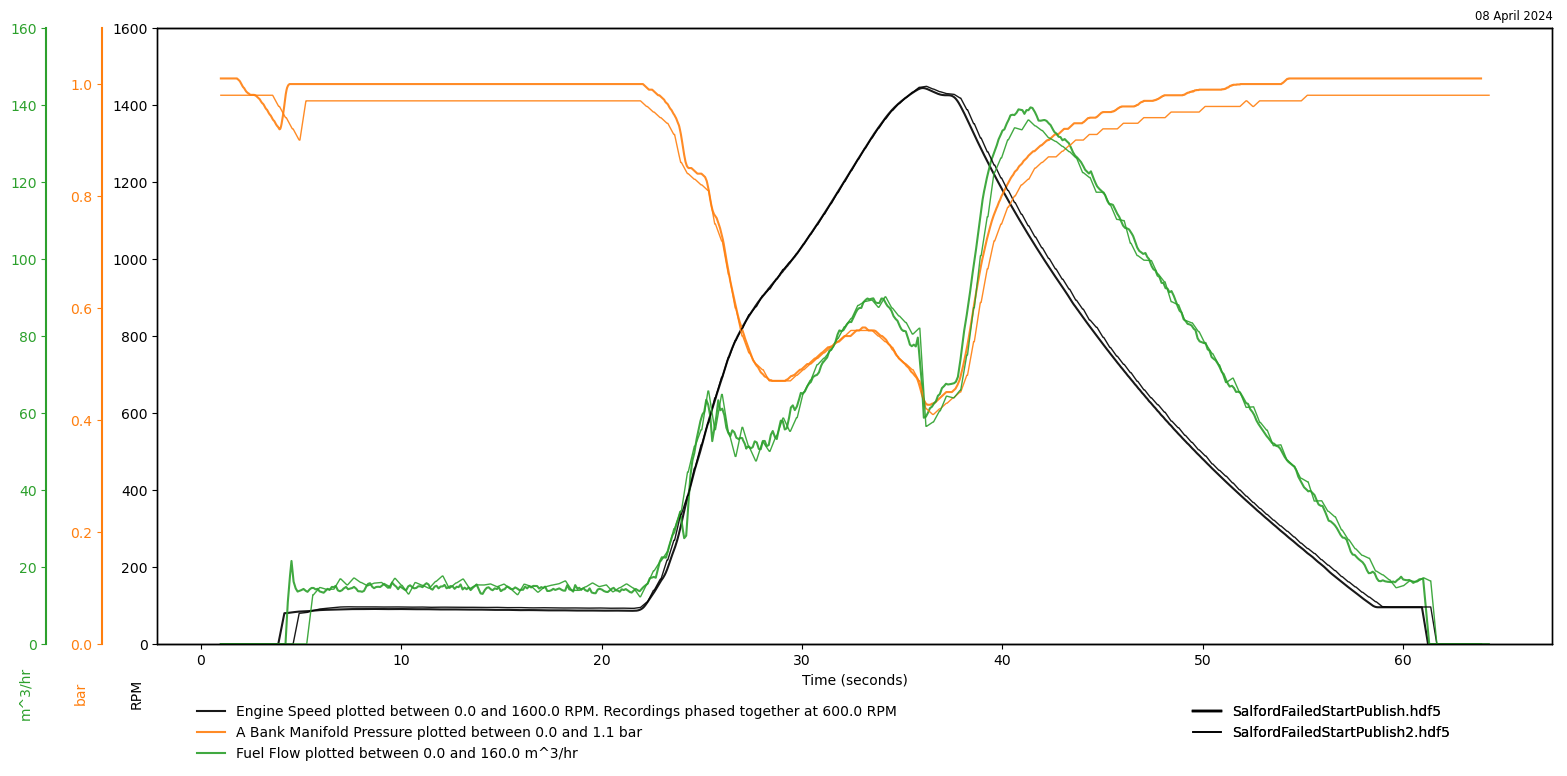

In [14]:

 
XScaleMax = PhasingPointTime + TimeAfter # Scaling for X Axis - MAX - NOT CURRENTLY USED!

## Generating the base plot
fig, ax1 = plt.subplots(figsize = (18,8)) 
ax1.plot() 

## Plot Title Generation - User defined or defaults to just the date. 
PlotTitle = input("\nType in the desired Plot Title ->   ")
if PlotTitle == "":
    PlotTitle = "%s"%(date.today().strftime("%d %B %Y"))
else:
    PlotTitle = "%s - %s"%(PlotTitle, date.today().strftime("%d %B %Y"))

plt.title(PlotTitle, loc="right", fontsize = "small")

##  Initial plot labelling and Y axis generation
plt.ylabel(ChannelUnits[PhasingColumn-1]) #Primary Y axis UNIT label inserted. PhasingColumn-1 used to get correct list indexing position. 
ax1.yaxis.set_label_coords(-0.01, -0.08)    # Positioned unit label under the axis itself - Trial and error - Small (0.001) changes have notable effect. 
plt.xlabel("Time (seconds)") # X axis label applied
plt.ylim(bottom=GlobalYAxisPlotValues[PhasingColumn-1][0], top=GlobalYAxisPlotValues[PhasingColumn-1][1]) # Defing the primary plot Y axis values from the Phasing Channel index position

   

Offset = 40 # Offset used to locate the additional Y axis positioning. Increments through += code within the adjustandplot function as an extra Y axis is plotted. 
LabelOffset = -0.05 # Offset for positioning additional Y axis labels.

## For function that ultimatly generates the additional Y axis on the plot. Goes through the axis defined by the user to be shown, checks to see that its not a phasing column and then intiates the AxisPlotter function. 
for AxisIndex in AxisList:

    if AxisIndex != PhasingColumn:
        AxisPlotter(AxisIndex, Offset, LabelOffset)
        ## Interating values for positional locating variables for subsequent axis being plotted. 
        Offset += 40
        LabelOffset -= 0.04

## Plotting reference setup - LineweightCounter - largest lineweight drawn. 

PlotCounter = 0
FileNameLegendLineList = []

## Primary plotting function. Generates all the data plots. Incremenets through each file to be plotted. If the file to be plotted is desinated to provide channel descriptions an additioanl true argument is sent into the function. 
for a in ImportFileList:
    
    if PlotCounter == ChannelDescriptionImportFileNumber: # Note that the channeldescriptionnumber has already been converted to be a suitable Index number. 
    
        AdjustAndPlot(a, True)
        PlotCounter += 1

    else:
        AdjustAndPlot(a, False)
        PlotCounter += 1



# Generating the addtional legend showing the file names with an assoaited lineweight for the files plotted. # See OneNote for explination. 

LegendFileList = [s[17:] for s in ImportFileList] # this extracts just the filename from the folder/filename string for each element in the list. Outputs a new list
first_legend = fig.legend(FileNameLegendLineList , LegendFileList , loc = "upper right", bbox_to_anchor=(0.85, 0.05), ncol=1, frameon=False)

# Add the legend manually to the current Axes.
ax = fig.gca().add_artist(first_legend)

# Plotting the name legend that shows the channels. All data from from the plotted information in the file selected to take channel information from. 
fig.legend( loc = "upper left", bbox_to_anchor=(0.14, 0.05), ncol=1, frameon=False)

# Saving the plot. bbox_inches=tight is very important. Ensures all the plot is saved. Without the artboard crops the legends off. 
plt.savefig("%s/%s.pdf"%(OutputFilePath, PlotTitle), format="pdf" , bbox_inches='tight')